# Generalizing Failure Circumstances

One central question in debugging is: _Does this bug occur in other situations, too?_ In this chapter, we present a technique that is set to _generalize_ the circumstances under which a failure occurs. The DDSET algorithm takes a failure-inducing input, breaks it into individual elements. For each element, it tries to find whether it can be replaced by others in the same category, and if so, it _generalizes_ the concrete element to the very category. The result is a _pattern_ that characterizes the failure condition: "The failure occurs for all inputs of the form `(<expr> * <expr>)`".

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("PV22XtIQU1s")

**Prerequisites**

* You should have read the [chapter on _delta debugging_](DeltaDebugger.ipynb).

In [2]:
import bookutils.setup

In [3]:
import DeltaDebugger

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.DDSetDebugger import <identifier>
```

and then make use of the following features.


This chapter provides a class `DDSetDebugger`, implementing the DDSET algorithm for generalizing failure-inducing inputs. The `DDSetDebugger` is used as follows:

```python
with DDSetDebugger(grammar) as dd:
    function(args...)
dd
```

Here, `function(args...)` is a failing function call (= raises an execption) that takes at least one string argument; `grammar` is an [input grammar in fuzzingbook format](https://www.fuzzingbook.org/html/Grammars.html) that matches the format of this argument.

The result is a call of `function()` with an _abstract failure-inducing input_ – a variant of the conrete input in which parts are replaced by placeholders in the form `<name>`, where `<name>` is a nonterminal in the grammar. The failure has been verified to occur for a number of instantiations of `<name>`.

Here is an example of how `DDSetDebugger` works. The concrete failing input `<foo>"bar</foo>` is generalized to an _abstract failure-inducing input_:

```python
>>> with DDSetDebugger(SIMPLE_HTML_GRAMMAR) as dd:
>>>     remove_html_markup('<foo>"bar</foo>')
>>> dd
remove_html_markup(s='<lt><id><gt>"<plain-text><closing-tag>')
```
The abstract input tells us that the failure occurs for whatever opening and closing HTML tags as long as there is a double quote between them.

A programmatic interface is available as well. `generalize()` returns a mapping of argument names to (generalized) values:

```python
>>> dd.generalize()
{'s': '<lt><id><gt>"<plain-text><closing-tag>'}
```
Using `fuzz()`, the abstract input can be instantiated to further concrete inputs, all set to produce the failure again:

```python
>>> for i in range(10):
>>>     print(dd.fuzz())
remove_html_markup(s='<s1d>"1</hF>')
remove_html_markup(s='<H>"c*C</l>')
remove_html_markup(s='<Ah2>"</v>')
remove_html_markup(s='<a7>")</NP>')
remove_html_markup(s='<boyIIt640TF>"</b08>')
remove_html_markup(s='<dF>"</fay>')
remove_html_markup(s='<l2>"\t7</z>')
remove_html_markup(s='<ci>"</t>')
remove_html_markup(s='<J>"2</t>')
remove_html_markup(s='<Fo9g>"\r~\t\r</D>')

```
`DDSetDebugger` can be customized by passing a subclass of `TreeGeneralizer`, which does the gist of the work; for details, see its constructor.
The full class hierarchy is shown below.

![](PICS/DDSetDebugger-synopsis-1.svg)



## A Failing Program

As with previous chapters, we use `remove_html_markup()` as our ongoing example. This function is set to remove HTML markup tags (like `<em>`) from a given string `s`, returning the plain text only. We use the version from [the chapter on asssertions](Assertions.ipynb), using an assertion as postcondition checker.

In [4]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

For the most inputs, `remove_html_markup()` works just as expected:

In [5]:
remove_html_markup("Be <em>quiet</em>, he said")

'Be quiet, he said'

There are inputs, however, for which it fails:

In [6]:
BAD_INPUT = '<foo>"bar</foo>'

In [7]:
from ExpectError import ExpectError

In [8]:
with ExpectError(AssertionError):
    remove_html_markup(BAD_INPUT)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/3787550988.py", line 2, in <cell line: 1>
    remove_html_markup(BAD_INPUT)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/2717035104.py", line 17, in remove_html_markup
    assert '<' not in out and '>' not in out
AssertionError (expected)


In [9]:
from bookutils import quiz

In contrast to the other chapters, our aim now is not to immediately go and debug `remove_html_markup()`. Instead, we focus on another important question: 

> Under which conditions precisely does `remove_html_markup()` fail?

This question can be generalized to

> What is the set of inputs for which `remove_html_markup()` fails?

Our plan for this is to _generalize_ concrete inputs (such as `BAD_INPUTS`) into an *abstract failure-inducing inputs*. These are patterns formed from a concrete input, but in which specific _placeholders_ indicate sets of inputs that are permitted. In the abstract failure-inducing input

```html
<opening-tag>"bar<closing-tag>
```

for instance, `<opening-tag>` and `<closing-tag>` are placeholders for opening and closing HTML tags, respectively. The pattern indicates that any opening HTML tag and closing HTML tag can be present in the input, as long as the enclosed text reads `"bar`.

Given a concrete failure-inducing input, our aim is to _generalize_ it as much as possible to such an abstract failure-inducing input. The resulting pattern should then

* capture the _circumstances_ under which the program fails;
* allow for _test generation_ by instantiating the placeholders;
* help ensuring our fix is as _general as possible_.

In [10]:
quiz("If `s = '<foo>\"bar</foo>'` (i.e., `BAD_INPUT`), "
     "what is the value of `out` such that the assertion fails?",
    [
        '`bar`',
        '`bar</foo>`',
        '`"bar</foo>`',
        '`<foo>"bar</foo>`',
    ], '9999999 // 4999999')

## Grammars

To determine abstract failure-inducing inputs, we need means to determine and characterize _sets of inputs_ – known in computer science as _languages_. To formally describe languages, the field of *formal languages* has devised a number of *language specifications* that describe a language.  *Regular expressions* represent the simplest class of these languages to denote sets of strings: The regular expression `[a-z]*`, for instance, denotes a (possibly empty) sequence of lowercase letters.  *Automata theory* connects these languages to automata that accept these inputs; *finite state machines*, for instance, can be used to specify the language of regular expressions.

Regular expressions are great for not-too-complex input formats, and the associated finite state machines have many properties that make them great for reasoning.  To specify more complex inputs, though, they quickly encounter limitations.  At the other end of the language spectrum, we have *universal grammars* that denote the language accepted by *Turing machines*.  A Turing machine can compute anything that can be computed; and with Python being Turing-complete, this means that we can also use a Python program $p$ to specify or even enumerate legal inputs. But then, computer science theory also tells us that each such program has to be written specifically for the input to be considered, which is not the level of automation we want.

The middle ground between regular expressions and Turing machines is covered by *grammars*.  Grammars are among the most popular (and best understood) formalisms to formally specify input languages.  Using a grammar, one can express a wide range of the properties of an input language.  Grammars are particularly great for expressing the *syntactical structure* of an input, and are the formalism of choice to express nested or recursive inputs.  The grammars we use are so-called *context-free grammars*, one of the easiest and most popular grammar formalisms.

A grammar is defined as a mapping of _nonterminal_ symbols (denoted in `<angle brackets>`) to lists of alternative _expansions_, which are strings containing _terminal_ symbols and possibly more _nonterminal_ symbols. To make the writing of grammars as simple as possible, we adopt the [fuzzingbook](https://www.fuzzingbook.org/) format that is based on strings and lists.

In [11]:
import fuzzingbook

Fuzzingbook grammars take the format of a _mapping_ between symbol names and expansions, where expansions are _lists_ of alternatives.

In [12]:
# ignore
from typing import Any, Callable, Optional, Type, Tuple
from typing import Dict, Union, List, cast, Generator

In [13]:
Grammar = Dict[str,  # A grammar maps strings...
               List[
                   Union[str,  # to list of strings...
                         Tuple[str, Dict[str, Any]]  # or to pairs of strings and attributes.
                        ]
               ]
              ]

A one-rule grammar for digits thus takes the form

In [14]:
DIGIT_GRAMMAR: Grammar = {
    "<start>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

which means that the `<start>` symbol can be expanded into any of the digits listed.

A full grammar for arithmetic expressions looks like this:

In [15]:
EXPR_GRAMMAR: Grammar = {
    "<start>":
        ["<expr>"],

    "<expr>":
        ["<term> + <expr>", "<term> - <expr>", "<term>"],

    "<term>":
        ["<factor> * <term>", "<factor> / <term>", "<factor>"],

    "<factor>":
        ["+<factor>",
         "-<factor>",
         "(<expr>)",
         "<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

From such a grammar, one can easily generate inputs that conform to the grammar.

In [16]:
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

In [17]:
simple_expr_fuzzer = GrammarFuzzer(EXPR_GRAMMAR)

In [18]:
for i in range(10):
    fuzz_expr = simple_expr_fuzzer.fuzz()
    print(fuzz_expr)

3.8 + --62.912 - ++4 - +5 * 3.0 * 4
7 * (75.5 - -6 + 5 - 4) + -(8 - 1) / 5 * 2
(-(9) * +6 + 9 / 3 * 8 - 9 * 8 / 7) / -+-65
(9 + 8) * 2 * (6 + 6 + 9) * 0 * 1.9 * 0
(1 * 7 - 9 + 5) * 5 / 0 * 5 + 7 * 5 * 7
-(6 / 9 - 5 - 3 - 1) - -1 / +1 + (9) / (8) * 6
(+-(0 - (1) * 7 / 3)) / ((1 * 3 + 8) + 9 - +1 / --0) - 5 * (-+939.491)
+2.9 * 0 / 501.19814 / --+--(6.05002)
+-8.8 / (1) * -+1 + -8 + 9 - 3 / 8 * 6 + 4 * 3 * 5
(+(8 / 9 - 1 - 7)) + ---06.30 / +4.39


Nonterminals as found in the grammar make natural _placeholders_ in abstract failure-inducing inputs. If we know, for instance, that it is not just the concrete failure-inducing input

```python
(2 * 3)
```

but the abstract failure-inducing input

```html
(<expr> * <expr>)
```

that causes the failure, we immediately see that the error is due to the multiplication operator rather than its operands.

Coming back to our `remove_html_markup()` example, let us create a simple grammar for HTML expressions. A `<html>` element is either plain text or tagged text.

In [19]:
SIMPLE_HTML_GRAMMAR: Grammar = {
    "<start>":
        ["<html>"],

    "<html>":
        ["<plain-text>", "<tagged-text>"],
}

Plain text is a simple (possibly empty) sequence of letter, digits, punctuation, and whitespace. (Note how `<plain-text>` is either empty or some character followed by more plain text.) The characters `<` and `>` are not allowed, though.

In [20]:
import string

In [21]:
SIMPLE_HTML_GRAMMAR.update({
    "<plain-text>":
        ["", "<plain-char><plain-text>"],

    "<plain-char>":
        ["<letter>", "<digit>", "<other>", "<whitespace>"],

    "<letter>": list(string.ascii_letters),
    "<digit>": list(string.digits),
    "<other>": list(string.punctuation.replace('<', '').replace('>', '')),
    "<whitespace>": list(string.whitespace)
})

Tagged text is a bit more complicated. We have opening tags `<foo>`, followed by some more HTML material, and then closed by a closing tag `</foo>`. (We do not insist that the two tags match.) A self-closing tag has the form `<br/>`. For compatibility reasons, we also allow just opening tags without closing tags, as in `<img>`.

In [22]:
SIMPLE_HTML_GRAMMAR.update({
    "<tagged-text>":
        ["<opening-tag><html><closing-tag>",
         "<self-closing-tag>",
         "<opening-tag>"],
})

Since the characters `<` and `>` are already reserved for denoting nonterminal symbols, we use the special nonterminal symbols `<lt>` and `<gt>` that expand into `<` and `>`, respectively,

In [23]:
SIMPLE_HTML_GRAMMAR.update({
    "<opening-tag>":
        ["<lt><id><gt>",
         "<lt><id><attrs><gt>"],

    "<lt>": ["<"],
    "<gt>": [">"],

    "<id>":
        ["<letter>", "<id><letter>", "<id><digit>"],

    "<closing-tag>":
        ["<lt>/<id><gt>"],

    "<self-closing-tag>":
        ["<lt><id><attrs>/<gt>"],
})

Finally, HTML tags can have attributes, which are enclosed in quotes.

In [24]:
SIMPLE_HTML_GRAMMAR.update({
    "<attrs>":
        ["<attr>", "<attr><attrs>" ],

    "<attr>":
        [" <id>='<plain-text>'",
         ' <id>="<plain-text>"'],
})

Again, we can generate inputs from the grammar.

In [25]:
simple_html_fuzzer = GrammarFuzzer(SIMPLE_HTML_GRAMMAR)

In [26]:
for i in range(10):
    fuzz_html = simple_html_fuzzer.fuzz()
    print(repr(fuzz_html))

'<T3 xG="">'
'<N9cd U=\'\' y=\'l1\' v0="" tb4ya="" UbD=\'\'>9</R>'
'\x0b'
' ea\\\\'
'&7'
"<c1 o2='' x9661lQo64T=''/>"
'<S4>'
'<GMS></wAu>'
'<j CI=\'\' T98sJ="" DR4=\'\'/>'
'<FQc90 Wt=""/>'


Such inputs, of course, are great for systematic testing. Our sister book, [the fuzzing book](https://www.fuzzingbook.org/), covers these and more.

## Derivation Trees

To produce inputs from a grammar, the fuzzingbook `GrammarFuzzer` makes use of a structure called a *derivation tree* (also known as *syntax tree*). A derivation tree encodes the individual expansion steps undertaken while producing the output.

In [27]:
DerivationTree = Tuple[str, Optional[List[Any]]]

Let us illustrate derivation trees by example, using the last HTML output we produced.

In [28]:
fuzz_html

'<FQc90 Wt=""/>'

The `GrammarFuzzer` attribute `derivation_tree` holds the last tree used to produce this input. We can visualize the tree as follows:

In [29]:
# ignore
from graphviz import Digraph

In [30]:
# ignore
def display_tree(tree: DerivationTree) -> Digraph:
    def graph_attr(dot: Digraph) -> None:
        dot.attr('node', shape='box', color='white', margin='0.0,0.0')
        dot.attr('node',
                 fontname="'Fira Mono', 'Source Code Pro', 'Courier', monospace")

    def node_attr(dot: Digraph, nid: str, symbol: str, ann: str) -> None:
        fuzzingbook.GrammarFuzzer.default_node_attr(dot, nid, symbol, ann)
        if symbol.startswith('<'):
            dot.node(repr(nid), fontcolor='#0060a0')
        else:
            dot.node(repr(nid), fontcolor='#00a060')
        dot.node(repr(nid), scale='2')

    return fuzzingbook.GrammarFuzzer.display_tree(tree,
        node_attr=node_attr,
        graph_attr=graph_attr)

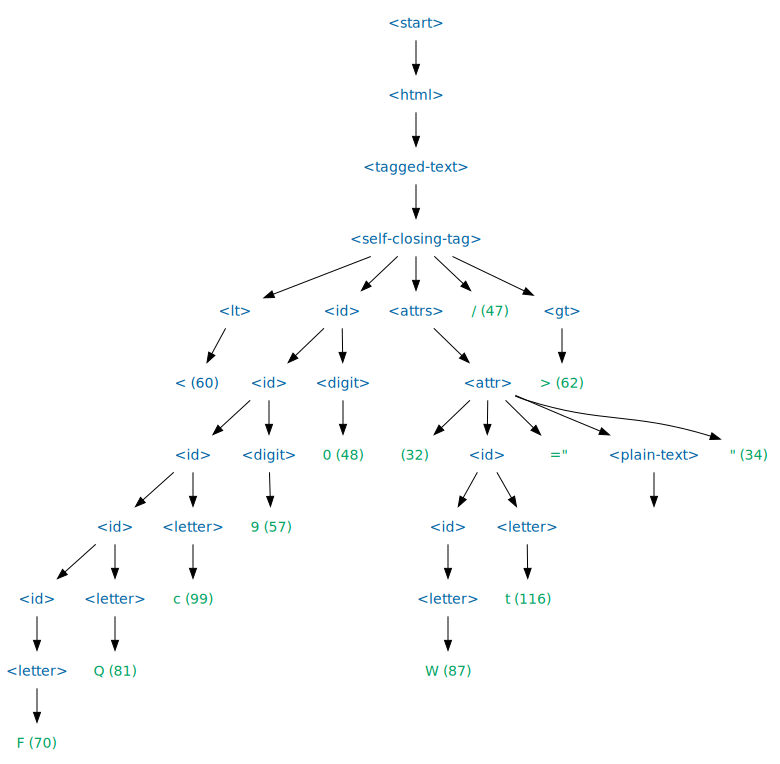

In [31]:
display_tree(simple_html_fuzzer.derivation_tree)

From top to bottom, we see that the input was constructed from a `<start>` symbol, which then expanded into `html`, which then expanded into HTML text, and so on. Multiple children in a tree stand for a concatenation of individual symbols.

Internally, these trees come as pairs `(symbol, children)`, where `symbol` is the name of a node (say, `<html>`), and `children` is a (possibly empty) list of subtrees. Here are the topmost nodes of the above tree:

In [32]:
import pprint

In [33]:
pp = pprint.PrettyPrinter(depth=7)
pp.pprint(simple_html_fuzzer.derivation_tree)

('<start>', [('<html>', [('<tagged-text>', [('<self-closing-tag>', [...])])])])


To produce abstract failure-inducing patterns, we will work on this very structure. The idea is to

1. systematically replace subtrees by other, generated, compatible subtrees (e.g. replace one `<html>` subtree in the concrete input by some other generated `<html>` subtree);
2. see whether these subtrees also result in failures; and
3. if they do, use the nonterminal (`<html>`) as a placeholder in the pattern.

This will involve some subtree manipulation, construction, and finally testing. First, though, we need to be able to turn an _existing input_ into a derivation tree.

## Parsing

The activity of creating a structure out of an unstructured input is called _parsing_. Generally speaking, a _parser_ uses a _grammar_ to create a _derivation tree_ (also called *parse tree* in parsing contexts) from a string input.

Again, there's a whole body of theory (and practice!) around constructing parsers. We make our life simple by using an existing parser (again, from [the fuzzing book](https://www.fuzzingbook.org/Parser.html)), which does just what we want. The `EarleyParser` is instantiated with a grammar such as `SIMPLE_HTML_GRAMMAR`:

In [34]:
from fuzzingbook.Parser import Parser, EarleyParser  # minor dependency

In [35]:
simple_html_parser = EarleyParser(SIMPLE_HTML_GRAMMAR)

Its method `parse()` returns an iterator over multiple possible derivation trees.  (There can be multiple trees because the grammar could be ambiguous). We are only interested in the first such tree. Let us parse `BAD_INPUT` and inspect the resulting ~parse tree~ ~syntax tree~ derivation tree:

In [36]:
bad_input_tree = list(simple_html_parser.parse(BAD_INPUT))[0]

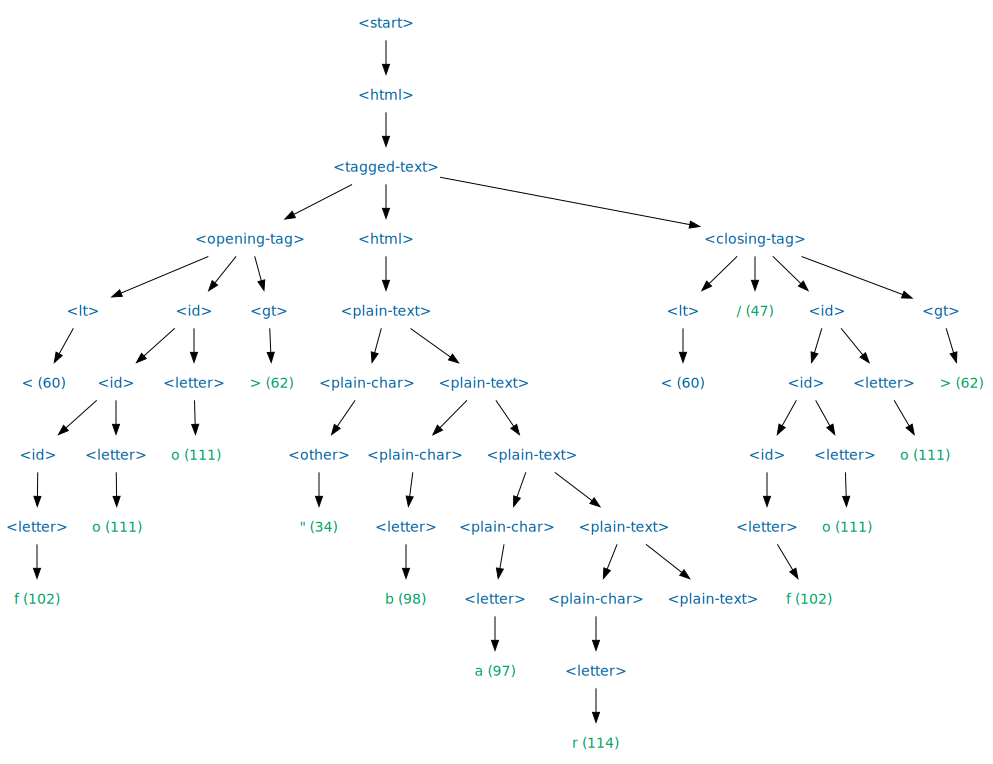

In [37]:
display_tree(bad_input_tree)

This derivation tree has the same structure as the one created from our `GrammarFuzzer` above. We see how the `<tagged-text>` is composed of three elements:

1. an`<opening-tag>` (`<foo>`);
2. a `<html>` element which becomes `<plain-text>` (`"bar`); and
3. a `<closing-tag>` (`</foo>`).

We can easily turn the tree back into a string. The method `tree_to_string()` traverses the tree left-to-right and joins all nonterminal symbols.

In [38]:
from fuzzingbook.GrammarFuzzer import tree_to_string, all_terminals

In [39]:
tree_to_string(bad_input_tree)

'<foo>"bar</foo>'

In [40]:
assert tree_to_string(bad_input_tree) == BAD_INPUT

With this, we can now

* parse an input into a tree structure;
* (re-)create parts of the tree structure; and
* turn the tree back into an input string.

## Mutating the Tree

We introduce a class `TreeMutator` that is set to mutate a tree. Its constructor takes a grammar and a tree.

In [41]:
from fuzzingbook.Grammars import is_valid_grammar

In [42]:
class TreeMutator:
    """Grammar-based mutations of derivation trees."""

    def __init__(self, grammar: Grammar, tree: DerivationTree,
                 fuzzer: Optional[GrammarFuzzer] = None, log: Union[bool, int] = False):
        """
        Constructor. 
        `grammar` is the underlying grammar; 
        `tree` is the tree to work on.
        `fuzzer` is the grammar fuzzer to use (default: `GrammarFuzzer`)
        """

        assert is_valid_grammar(grammar)
        self.grammar = grammar
        self.tree = tree
        self.log = log

        if fuzzer is None:
            fuzzer = GrammarFuzzer(grammar)

        self.fuzzer = fuzzer

### Referencing Subtrees

To reference individual elements in the tree, we introduce the concept of a _path_. A path is a list of numbers indicating the children (starting with 0) we should follow. A path `[0, 0, 0, ..., 0]` stands for the leftmost child in a tree.

In [43]:
TreePath = List[int]

The method `get_subtree()` returns the subtree for a given path.

In [44]:
class TreeMutator(TreeMutator):
    def get_subtree(self, path: TreePath, tree: Optional[DerivationTree] = None) -> DerivationTree:
        """Access a subtree based on `path` (a list of children numbers)"""
        if tree is None:
            tree = self.tree

        symbol, children = tree

        if not path or children is None:
            return tree

        return self.get_subtree(path[1:], children[path[0]])

Here's `get_subtree()` in action. We instantiate a `TreeMutator` on the `BAD_INPUT` tree as shown above and return the element at the path `[0, 0, 1, 0]` – i.e. follow the leftmost edge twice, than the second-to-leftmost edge, then the leftmost edge again. This gives us the `<plain-text>` subtree representing the string `"bar`:

In [45]:
def bad_input_tree_mutator() -> TreeMutator:
    return TreeMutator(SIMPLE_HTML_GRAMMAR, bad_input_tree, log=2)    

In [46]:
plain_text_subtree = bad_input_tree_mutator().get_subtree([0, 0, 1, 0])
pp.pprint(plain_text_subtree)

('<plain-text>',
 [('<plain-char>', [('<other>', [('"', [])])]),
  ('<plain-text>',
   [('<plain-char>', [('<letter>', [...])]),
    ('<plain-text>', [('<plain-char>', [...]), ('<plain-text>', [...])])])])


In [47]:
tree_to_string(plain_text_subtree)

'"bar'

In [48]:
# ignore
def primes_generator() -> Generator[int, None, None]:
    # Adapted from https://www.python.org/ftp/python/doc/nluug-paper.ps
    primes = [2]
    yield 2
    i = 3
    while True:
        for p in primes:
            if i % p == 0 or p * p > i:
                break

        if i % p != 0:
            primes.append(i)
            yield i

        i += 2

In [49]:
# ignore
prime_numbers = primes_generator()

In [50]:
quiz("In `bad_input_tree`, what is "
     " the subtree at the path `[0, 0, 2, 1]` as string?", 
    [
        f"`{tree_to_string(bad_input_tree_mutator().get_subtree([0, 0, 2, 0]))}`",
        f"`{tree_to_string(bad_input_tree_mutator().get_subtree([0, 0, 2, 1]))}`",
        f"`{tree_to_string(bad_input_tree_mutator().get_subtree([0, 0, 2]))}`",
        f"`{tree_to_string(bad_input_tree_mutator().get_subtree([0, 0, 0]))}`",
    ], 'next(prime_numbers)', globals()
    )

### Creating new Subtrees

The method `new_tree()` creates a new subtree for the given `<start_symbol>` according to the rules of the grammar. It invokes `expand_tree()` on the given `GrammarFuzzer` – a method that takes an initial (empty) tree and expands it until no more expansions are left.

In [51]:
class TreeMutator(TreeMutator):
    def new_tree(self, start_symbol: str) -> DerivationTree:
        """Create a new subtree for <start_symbol>."""

        if self.log >= 2:
            print(f"Creating new tree for {start_symbol}")

        tree = (start_symbol, None)
        return self.fuzzer.expand_tree(tree)

Here is an example of `new_tree()`:

Creating new tree for <plain-text>


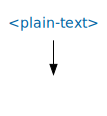

In [52]:
plain_text_tree = cast(TreeMutator, bad_input_tree_mutator()).new_tree('<plain-text>')
display_tree(plain_text_tree)

In [53]:
tree_to_string(plain_text_tree)

''

### Mutating the Tree

With us now being able to 
* access a particular path in the tree (`get_subtree()`) and
* create a new subtree (`new_tree()`),

we can mutate the tree at a given path. This is the task of `mutate()`.

In [54]:
class TreeMutator(TreeMutator):
    def mutate(self, path: TreePath, tree: Optional[DerivationTree] = None) -> DerivationTree:
        """Return a new tree mutated at `path`"""
        if tree is None:
            tree = self.tree
        assert tree is not None

        symbol, children = tree

        if not path or children is None:
            return self.new_tree(symbol)

        head = path[0]
        new_children = (children[:head] +
                        [self.mutate(path[1:], children[head])] +
                        children[head + 1:])
        return symbol, new_children

Here is an example of `mutate()` in action. We mutate `bad_input_tree` at the path `[0, 0, 1, 0]` – that is, `<plain-text>`:

Creating new tree for <plain-text>


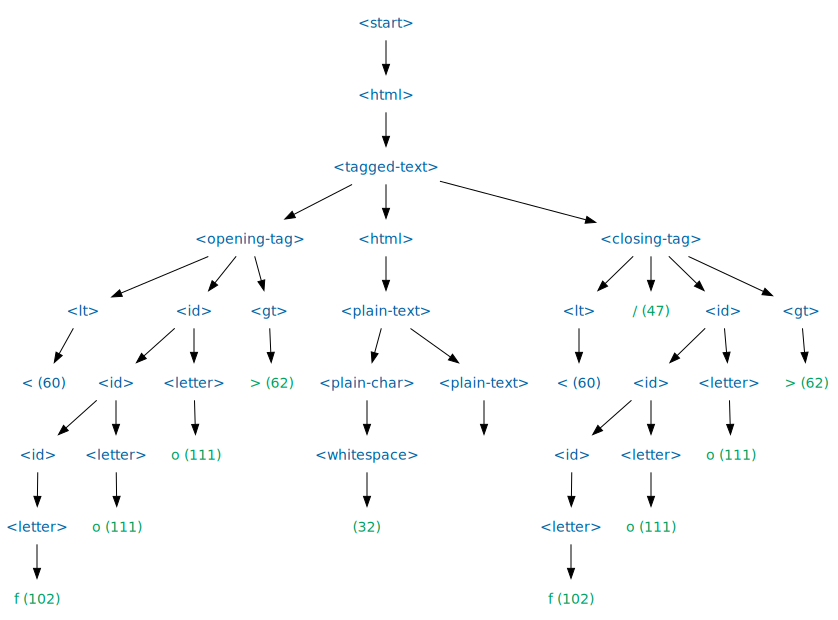

In [55]:
mutated_tree = cast(TreeMutator, bad_input_tree_mutator()).mutate([0, 0, 1, 0])
display_tree(mutated_tree)

We see that the `<plain-text>` subtree is now different, which also becomes evident in the string representation.

In [56]:
tree_to_string(mutated_tree)

'<foo> </foo>'

## Generalizing Trees

Now for the main part – finding out which parts of a tree can be generalized. Our idea is to _test_ a finite number of mutations to a subtree (say, 10). If all of these tests fail as well, then we assume we can generalize the subtree to a placeholder.

We introduce a class `TreeGeneralizer` for this purpose. On top of `grammar` and `tree` already used for the `TreeMutator` constructor, the `TreeGeneralizer` also takes a `test` function.

In [57]:
class TreeGeneralizer(TreeMutator):
    """Determine which parts of a derivation tree can be generalized."""

    def __init__(self, grammar: Grammar, tree: DerivationTree, test: Callable,
                 max_tries_for_generalization: int = 10, **kwargs: Any) -> None:
        """
        Constructor. `grammar` and `tree` are as in `TreeMutator`.
        `test` is a function taking a string that either
          * raises an exception, indicating test failure;
          * or not, indicating test success.
        `max_tries_for_generalization` is the number of times
        an instantiation has to fail before it is generalized.
        """

        super().__init__(grammar, tree, **kwargs)
        self.test = test
        self.max_tries_for_generalization = max_tries_for_generalization

The `test` function is used in `test_tree()`, returning `False` if the test fails (raising an exception), and `True` if the test passes (no exception).

In [58]:
class TreeGeneralizer(TreeGeneralizer):
    def test_tree(self, tree: DerivationTree) -> bool:
        """Return True if testing `tree` passes, else False"""
        s = tree_to_string(tree)
        if self.log:
            print(f"Testing {repr(s)}...", end="")
        try:
            self.test(s)
        except Exception as exc:
            if self.log:
                print(f"FAIL ({type(exc).__name__})")
            ret = False
        else:
            if self.log:
                print(f"PASS")
            ret = True

        return ret

### Testing for Generalization

The `can_generalize()` method brings the above methods together. It creates a number of tree mutations at the given path, and returns True if all of them produce a failure. (Note that this is not as sophisticated as our [delta debugger](DeltaDebugger.ipynb) implementation, which also checks that the _same_ error occurs.)

In [59]:
class TreeGeneralizer(TreeGeneralizer):
    def can_generalize(self, path: TreePath, tree: Optional[DerivationTree] = None) -> bool:
        """Return True if the subtree at `path` can be generalized."""
        for i in range(self.max_tries_for_generalization):
            mutated_tree = self.mutate(path, tree)
            if self.test_tree(mutated_tree):
                # Failure no longer occurs; cannot abstract
                return False

        return True

Let us put `TreeGeneralizer` into action. We can directly use `remove_html_markup()` as test function.

In [60]:
def bad_input_tree_generalizer(**kwargs: Any) -> TreeGeneralizer:
    return TreeGeneralizer(SIMPLE_HTML_GRAMMAR, bad_input_tree,
                           remove_html_markup, **kwargs)

On our `BAD_INPUT` (and its tree), can we generalize the root `<html>` node? In other words, does the failure occur for all possible `<html>` inputs?

In [61]:
bad_input_tree_generalizer(log=True).can_generalize([0])

Testing "<l35Gmq W2G571=''>"...PASS


False

The answer is no. The first alternative passes the test; hence no generalization.

How about the middle `<plain_text>` part? Can we generalize this?

In [62]:
bad_input_tree_generalizer(log=True).can_generalize([0, 0, 1, 0])

Testing '<foo>8</foo>'...PASS


False

The answer is no – just as above.

How about the closing tag? Can we generalize this one?

In [63]:
bad_input_tree_generalizer(log=True).can_generalize([0, 0, 2])

Testing '<foo>"bar</e7N>'...FAIL (AssertionError)
Testing '<foo>"bar</q37A>'...FAIL (AssertionError)
Testing '<foo>"bar</W>'...FAIL (AssertionError)
Testing '<foo>"bar</z93Q5>'...FAIL (AssertionError)
Testing '<foo>"bar</WR>'...FAIL (AssertionError)
Testing '<foo>"bar</m>'...FAIL (AssertionError)
Testing '<foo>"bar</Uy443wt1h7>'...FAIL (AssertionError)
Testing '<foo>"bar</fon2>'...FAIL (AssertionError)
Testing '<foo>"bar</M>'...FAIL (AssertionError)
Testing '<foo>"bar</g9>'...FAIL (AssertionError)


True

Yes, we can! All alternate instantiations of `<closing-tag>` result in a failure.

In [64]:
quiz("Is this also true for `<opening-tag>`?",
     [
         "Yes",
         "No"
     ], '("Yes" == "Yes") + ("No" == "No")')

Note that the above does not hold for `<opening-tag>`. If the attribute value contains a quote character, it will extend to the end of the input. This is another error, but not caught by our assertion; hence, the input will be flagged as passing:

In [65]:
BAD_ATTR_INPUT = '<foo attr="\'">bar</foo>'

In [66]:
remove_html_markup(BAD_ATTR_INPUT)

''

The effect of this is that there are patterns for `<opening-tag>` which do not cause the failure to occur; hence, `<opening-tag>` is not a fully valid generalization.

This, however, becomes apparent only if one of our generated tests includes a quote character in the attribute value. Since quote characters are as likely (or as unlikely) to appear as other characters, this effect may not become apparent in our default 10 tests:

In [67]:
bad_input_tree_generalizer().can_generalize([0, 0, 0])

True

It will become apparent, however, as we increase the number of tests:

In [68]:
bad_input_tree_generalizer(max_tries_for_generalization=100, log=True).can_generalize([0, 0, 0])

Testing '<Ada np=\'7\' y7v=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<B V=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<K v="$" s5F="\x0b" q="" E=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<Fcdt8 v7A4u=\'.\t\'>"bar</foo>'...FAIL (AssertionError)
Testing '<s n="">"bar</foo>'...FAIL (AssertionError)
Testing '<W>"bar</foo>'...FAIL (AssertionError)
Testing '<ap>"bar</foo>'...FAIL (AssertionError)
Testing '<B1>"bar</foo>'...FAIL (AssertionError)
Testing '<Q00wY M=\'\r \'>"bar</foo>'...FAIL (AssertionError)
Testing '<O6 d7="" H=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<v1IH w="" ZI="" O="">"bar</foo>'...FAIL (AssertionError)
Testing '<T1 w998=\'a\' j=\'z\n7\'>"bar</foo>'...FAIL (AssertionError)
Testing '<Dnh1>"bar</foo>'...FAIL (AssertionError)
Testing '<D F9="" x4=\'\' Hup=\'7\n\'>"bar</foo>'...FAIL (AssertionError)
Testing '<l62E>"bar</foo>'...FAIL (AssertionError)
Testing '<k11 P8x5="">"bar</foo>'...FAIL (AssertionError)
Testing '<V6LBVu>"bar</foo>'...FAIL (As

False

We see that our approach may _overgeneralize_ – producing a generalization that may be too lenient. In practice, this is not too much of a problem, as we would be interested in characterizing cases that trigger the failure, rather than characterizing a small subset that does not trigger the failure.

### Generalizable Paths

Using `can_generalize()`, we can devise a method `generalizable_paths()` that returns all paths in the tree that can be generalized.

In [69]:
class TreeGeneralizer(TreeGeneralizer):
    def find_paths(self, 
                   predicate: Callable[[TreePath, DerivationTree], bool], 
                   path: Optional[TreePath] = None, 
                   tree: Optional[DerivationTree] = None) -> List[TreePath]:
        """
        Return a list of all paths for which `predicate` holds.
        `predicate` is a function `predicate`(`path`, `tree`), where
        `path` denotes a subtree in `tree`. If `predicate()` returns
        True, `path` is included in the returned list.
        """

        if path is None:
            path = []
        assert path is not None

        if tree is None:
            tree = self.tree
        assert tree is not None

        symbol, children = self.get_subtree(path)

        if predicate(path, tree):
            return [path]

        paths = []
        if children is not None:
            for i, child in enumerate(children):
                child_symbol, _ = child
                if child_symbol in self.grammar:
                    paths += self.find_paths(predicate, path + [i])

        return paths

    def generalizable_paths(self) -> List[TreePath]:
        """Return a list of all paths whose subtrees can be generalized."""
        return self.find_paths(self.can_generalize)

Here is `generalizable_paths()` in action. We obtain all (paths to) subtrees that can be generalized:

In [70]:
bad_input_generalizable_paths = \
    cast(TreeGeneralizer, bad_input_tree_generalizer()).generalizable_paths()
bad_input_generalizable_paths

[[0, 0, 0], [0, 0, 1, 0, 1, 0], [0, 0, 1, 0, 1, 1], [0, 0, 2]]

To convert these subtrees into abstract failure-inducing patterns, the method `generalize_path()` returns a copy of the tree with the subtree replaced by a nonterminal without children:

In [71]:
class TreeGeneralizer(TreeGeneralizer):
    def generalize_path(self, path: TreePath, 
                        tree: Optional[DerivationTree] = None) -> DerivationTree:
        """Return a copy of the tree in which the subtree at `path`
        is generalized (= replaced by a nonterminal without children)"""

        if tree is None:
            tree = self.tree
        assert tree is not None

        symbol, children = tree

        if not path or children is None:
            return symbol, None  # Nonterminal without children

        head = path[0]
        new_children = (children[:head] +
                        [self.generalize_path(path[1:], children[head])] +
                        children[head + 1:])
        return symbol, new_children

The function `all_terminals()` expands these placeholders:

In [72]:
all_terminals(cast(TreeGeneralizer, bad_input_tree_generalizer()).generalize_path([0, 0, 0]))

'<opening-tag>"bar<plain-text></foo>'

Finally, the method `generalize()` obtains a tree in which all generalizable paths actually are generalized:

In [73]:
class TreeGeneralizer(TreeGeneralizer):
    def generalize(self) -> DerivationTree:
        """Returns a copy of the tree in which all generalizable subtrees
        are generalized (= replaced by nonterminals without children)"""
        tree = self.tree
        assert tree is not None

        for path in self.generalizable_paths():
            tree = self.generalize_path(path, tree)

        return tree

In [74]:
abstract_failure_inducing_input = cast(TreeGeneralizer, bad_input_tree_generalizer()).generalize()

This gives us the final generalization of `BAD_INPUT`. In the abstract failure-inducing input, all generalizable elements are generalized.

In [75]:
all_terminals(abstract_failure_inducing_input)

'<opening-tag>"<plain-text><closing-tag>'

We see that to obtain the failure, it suffices to have an `<opening-tag>`, followed by a quote and (any) `<plain-text>` and (any) `<closing-tag>`. Clearly, all that it takes to produce the failure is to have a double quote in the plain text.

Also note how this diagnosis was reached through _experiments_ only – just as with [delta debugging](DeltaDebugger.ipynb), we could treat the program under test as a black box. In contrast to delta debugging, however, we obtain an _abstraction_ that generalizes the circumstances under which a given failure occurs.

## Fuzzing with Patterns

One neat side effect of abstract failure-inducing patterns is that they can be easily instantiated into further test cases, all set to reproduce the failure in question. This gives us a test suite we can later test our fix against.

The method `fuzz_tree()` takes a tree representing an abstract failure-inducing input and instantiates all missing subtrees.

In [76]:
import copy

In [77]:
class TreeGeneralizer(TreeGeneralizer):
    def fuzz_tree(self, tree: DerivationTree) -> DerivationTree:
        """Return an instantiated copy of `tree`."""
        tree = copy.deepcopy(tree)
        return self.fuzzer.expand_tree(tree)

In [78]:
bitg = cast(TreeGeneralizer, bad_input_tree_generalizer())
for i in range(10):
    print(all_terminals(bitg.fuzz_tree(abstract_failure_inducing_input)))

<UzL3Ct6>"</p>
<nw10E6>"</W>
<h lV="'">"</x8>
<k>"</u>
<a0 l0820650g='3'>"</v5t>
<zTg>"</o1Z>
<yMgT02p s="" g94e='R'>"</P2>
<Y>"</S9b>
<X2566xS8v2>"</r13>
<D48>"	</R>


We can take these inputs and see whether they reproduce the failure in question:

In [79]:
successes = 0
failures = 0
trials = 1000

for i in range(trials):
    test_input = all_terminals(
        bitg.fuzz_tree(abstract_failure_inducing_input))
    try:
        remove_html_markup(test_input)
    except AssertionError:
        successes += 1
    else:
        failures += 1

In [80]:
successes, failures

(982, 18)

We get an overall failure rate of ~98%, which is not bad at all.

In [81]:
failures / 1000

0.018

In our case, it is _overgeneralization_ (as discussed above) that is responsible for not reaching a 100% rate. (In all generality, we are trying to approximate the behavior of a Turing machine with a context free grammar, which is, well, always an approximation.) However, even a lower rate would still be useful, as any additional test case that reproduces a failure helps in ensuring the final fix is complete.

## Putting it all Together

Let us now put together all this in a more convenient package that does not require the user to parse and unparse derivation trees.

Our `DDSetDebugger` is modeled after the `DeltaDebugger` from [the chapter on delta debugging](DeltaDebugger.ipynb). It is to be used as

```python
with DDSetDebugger(grammar) as dd:
    some_failing_function(...)
```

After that, evaluating `dd` yields a generalized abstract failure-inducing input as a string.

Since `DDSetDebugger` accepts only one grammar, the function to be debugged should have exactly one string argument (besides other arguments); this string must fit the grammar.

### Constructor

The constructor puts together the various components. It allows for customization by subclassing.

In [82]:
from DeltaDebugger import CallCollector

In [83]:
class DDSetDebugger(CallCollector):
    """
    Debugger implementing the DDSET algorithm for abstracting failure-inducing inputs.
    """

    def __init__(self, grammar: Grammar, 
                 generalizer_class: Type = TreeGeneralizer,
                 parser: Optional[Parser] = None,
                 **kwargs: Any) -> None:
        """Constructor.
        `grammar` is an input grammar in fuzzingbook format.
        `generalizer_class` is the tree generalizer class to use
        (default: `TreeGeneralizer`)
        `parser` is the parser to use (default: `EarleyParser(grammar)`).
        All other keyword args are passed to the tree generalizer, notably:
        `fuzzer` - the fuzzer to use (default: `GrammarFuzzer`), and
        `log` - enables debugging output if True.
        """
        super().__init__()
        self.grammar = grammar
        assert is_valid_grammar(grammar)

        self.generalizer_class = generalizer_class

        if parser is None:
            parser = EarleyParser(grammar)
        self.parser = parser
        self.kwargs = kwargs

        # These save state for further fuzz() calls
        self.generalized_args: Dict[str, Any] = {}
        self.generalized_trees: Dict[str, DerivationTree] = {}
        self.generalizers: Dict[str, TreeGeneralizer] = {}

### Generalizing Arguments

The method `generalize()` is the main entry point. For all string arguments collected in the first function call, it generalizes the arguments and returns an abstract failure-inducing string.

In [84]:
class DDSetDebugger(DDSetDebugger):
    def generalize(self) -> Dict[str, Any]:
        """
        Generalize arguments seen. For each function argument,
        produce an abstract failure-inducing input that characterizes
        the set of inputs for which the function fails.
        """
        if self.generalized_args:
            return self.generalized_args

        self.generalized_args = copy.deepcopy(self.args())
        self.generalized_trees = {}
        self.generalizers = {}

        for arg in self.args():
            def test(value: Any) -> Any:
                return self.call({arg: value})

            value = self.args()[arg]
            if isinstance(value, str):
                tree = list(self.parser.parse(value))[0]
                gen = self.generalizer_class(self.grammar, tree, test, 
                                             **self.kwargs)
                generalized_tree = gen.generalize()

                self.generalizers[arg] = gen
                self.generalized_trees[arg] = generalized_tree
                self.generalized_args[arg] = all_terminals(generalized_tree)

        return self.generalized_args

In [85]:
class DDSetDebugger(DDSetDebugger):
    def __repr__(self) -> str:
        """Return a string representation of the generalized call."""
        return self.format_call(self.generalize())

Here is an example of how `DDSetDebugger` would be used on our `BAD_INPUT` example. Simply evaluating the debugger yields a call with a generalized input.

In [86]:
with DDSetDebugger(SIMPLE_HTML_GRAMMAR) as dd:
    remove_html_markup(BAD_INPUT)
dd

remove_html_markup(s='<opening-tag>"<plain-text><closing-tag>')

### Fuzzing

The `fuzz()` method produces instantiations of the abstract failure-inducing pattern.

In [87]:
class DDSetDebugger(DDSetDebugger):
    def fuzz_args(self) -> Dict[str, Any]:
        """
        Return arguments randomly instantiated
        from the abstract failure-inducing pattern.
        """
        if not self.generalized_trees:
            self.generalize()

        args = copy.deepcopy(self.generalized_args)
        for arg in args:
            if arg not in self.generalized_trees:
                continue

            tree = self.generalized_trees[arg]
            gen = self.generalizers[arg]
            instantiated_tree = gen.fuzz_tree(tree)
            args[arg] = all_terminals(instantiated_tree)

        return args

    def fuzz(self) -> str:
        """
        Return a call with arguments randomly instantiated
        from the abstract failure-inducing pattern.
        """
        return self.format_call(self.fuzz_args())

Here are some axamples of `fuzz()` in action:

In [88]:
with DDSetDebugger(SIMPLE_HTML_GRAMMAR) as dd:
    remove_html_markup(BAD_INPUT)

In [89]:
dd.fuzz()

'remove_html_markup(s=\'<Xq>"</j>\')'

In [90]:
dd.fuzz()

'remove_html_markup(s=\'<L89B6b9vz>"\\t</a3>\')'

In [91]:
dd.fuzz()

'remove_html_markup(s=\'<Z VF=\\\'\\\' l="_-(">")</Y>\')'

 These can be fed into `eval()`, set to produce more failing calls.

In [92]:
with ExpectError(AssertionError):
    eval(dd.fuzz())

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/2072246869.py", line 2, in <cell line: 1>
    eval(dd.fuzz())
  File "<string>", line 1, in <module>
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/2717035104.py", line 17, in remove_html_markup
    assert '<' not in out and '>' not in out
AssertionError (expected)


## More Examples

Let us apply `DDSetDebugger` on more examples.

### Square Root

Our first example is the `square_root()` function from [the chapter on assertions](Assertions.ipynb).

In [93]:
from Assertions import square_root  # minor dependency

The `square_root()` function fails on a value of `-1`:

In [94]:
with ExpectError(AssertionError):
    square_root(-1)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/1205325604.py", line 2, in <cell line: 1>
    square_root(-1)
  File "/Users/zeller/Projects/debuggingbook/notebooks/Assertions.ipynb", line 55, in square_root
    assert x >= 0  # precondition
AssertionError (expected)


We define a grammar for its arguments:

In [95]:
INT_GRAMMAR: Grammar = {
    "<start>":
        ["<int>"],

    "<int>":
        ["<positive-int>", "-<positive-int>"],

    "<positive-int>":
        ["<digit>", "<nonzero-digit><positive-int>"],

    "<nonzero-digit>": list("123456789"),
    
    "<digit>": list(string.digits),
}

The test function takes a string and converts it into an integer:

In [96]:
def square_root_test(s: str) -> None:
    return square_root(int(s))

With this, we can go and see whether we can generalize a failing input:

In [97]:
with DDSetDebugger(INT_GRAMMAR, log=True) as dd_square_root:
    square_root_test("-1")

In [98]:
dd_square_root

Testing '-8'...FAIL (AssertionError)
Testing '-316'...FAIL (AssertionError)
Testing '8'...PASS
Testing '684'...PASS
Testing '-3'...FAIL (AssertionError)
Testing '-870'...FAIL (AssertionError)
Testing '-3'...FAIL (AssertionError)
Testing '-3451'...FAIL (AssertionError)
Testing '-8'...FAIL (AssertionError)
Testing '-63213'...FAIL (AssertionError)
Testing '-26'...FAIL (AssertionError)
Testing '-4'...FAIL (AssertionError)
Testing '-6'...FAIL (AssertionError)
Testing '-8'...FAIL (AssertionError)


square_root_test(s='-<positive-int>')

Success! Using `DDSetDebugger`, we have nicely generalized the failure-inducing input to a pattern `-<positive-int>` that translates into "any negative number".

### Middle

The `middle()` function from [the chapter on statistical debugging](StatisticalDebugger.ipynb) returns the middle of three numerical values `x`, `y`, and `z`.

In [99]:
from StatisticalDebugger import middle  # minor dependency

We set up a test function that evaluates a string – a tuple of three arguments – and then tests `middle()`:

In [100]:
def middle_test(s: str) -> None:
    x, y, z = eval(s)
    assert middle(x, y, z) == sorted([x, y, z])[1]

The grammar for the three numbers simply puts three integers together:

In [101]:
XYZ_GRAMMAR: Grammar = {
    "<start>":
        ["<int>, <int>, <int>"],

    "<int>":
        ["<positive-int>", "-<positive-int>"],

    "<positive-int>":
        ["<digit>", "<nonzero-digit><positive-int>"],

    "<nonzero-digit>": list("123456789"),
    
    "<digit>": list(string.digits),
}

Here is an example of `middle()` failing:

In [102]:
with ExpectError(AssertionError):
    middle_test("2, 1, 3")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/982110330.py", line 2, in <cell line: 1>
    middle_test("2, 1, 3")
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73413/3079946275.py", line 3, in middle_test
    assert middle(x, y, z) == sorted([x, y, z])[1]
AssertionError (expected)


What happens if we debug this with `DDSetDebugger`? We see that there is no abstraction at the syntax level that could characterize this failure:

In [103]:
with DDSetDebugger(XYZ_GRAMMAR, log=True) as dd_middle:
    middle_test("2, 1, 3")

In [104]:
dd_middle

Testing '7, 4591, -0'...PASS
Testing '6, 1, 3'...PASS
Testing '7, 1, 3'...PASS
Testing '7, 1, 3'...PASS
Testing '2, -7, 3'...FAIL (AssertionError)
Testing '2, 0, 3'...FAIL (AssertionError)
Testing '2, -89, 3'...FAIL (AssertionError)
Testing '2, 973, 3'...PASS
Testing '2, 11, 3'...PASS
Testing '2, 8, 3'...PASS
Testing '2, 1, 9'...FAIL (AssertionError)
Testing '2, 1, -16'...PASS
Testing '2, 1, 35'...FAIL (AssertionError)
Testing '2, 1, 6'...FAIL (AssertionError)
Testing '2, 1, 53'...FAIL (AssertionError)
Testing '2, 1, 5'...FAIL (AssertionError)
Testing '2, 1, 737'...FAIL (AssertionError)
Testing '2, 1, 28'...FAIL (AssertionError)
Testing '2, 1, 3'...FAIL (AssertionError)
Testing '2, 1, 5'...FAIL (AssertionError)
Testing '2, 1, 5'...FAIL (AssertionError)
Testing '2, 1, 56'...FAIL (AssertionError)


middle_test(s='2, 1, <positive-int>')

So, while there are failures that can be nicely characterized using abstractions of input elements, `middle()` is not one of them. Which is good, because this means that all our other techniques such as [statistical debugging](StatisticalDebugger.ipynb) and [dynamic invariants](DynamicInvariants.ipynb) still have a use case :-)

## Synopsis

This chapter provides a class `DDSetDebugger`, implementing the DDSET algorithm for generalizing failure-inducing inputs. The `DDSetDebugger` is used as follows:

```python
with DDSetDebugger(grammar) as dd:
    function(args...)
dd
```

Here, `function(args...)` is a failing function call (= raises an execption) that takes at least one string argument; `grammar` is an [input grammar in fuzzingbook format](https://www.fuzzingbook.org/html/Grammars.html) that matches the format of this argument.

The result is a call of `function()` with an _abstract failure-inducing input_ – a variant of the conrete input in which parts are replaced by placeholders in the form `<name>`, where `<name>` is a nonterminal in the grammar. The failure has been verified to occur for a number of instantiations of `<name>`.

Here is an example of how `DDSetDebugger` works. The concrete failing input `<foo>"bar</foo>` is generalized to an _abstract failure-inducing input_:

In [105]:
with DDSetDebugger(SIMPLE_HTML_GRAMMAR) as dd:
    remove_html_markup('<foo>"bar</foo>')
dd

remove_html_markup(s='<lt><id><gt>"<plain-text><closing-tag>')

The abstract input tells us that the failure occurs for whatever opening and closing HTML tags as long as there is a double quote between them.

A programmatic interface is available as well. `generalize()` returns a mapping of argument names to (generalized) values:

In [106]:
dd.generalize()

{'s': '<lt><id><gt>"<plain-text><closing-tag>'}

Using `fuzz()`, the abstract input can be instantiated to further concrete inputs, all set to produce the failure again:

In [107]:
for i in range(10):
    print(dd.fuzz())

remove_html_markup(s='<s1d>"1</hF>')
remove_html_markup(s='<H>"c*C</l>')
remove_html_markup(s='<Ah2>"</v>')
remove_html_markup(s='<a7>")</NP>')
remove_html_markup(s='<boyIIt640TF>"</b08>')
remove_html_markup(s='<dF>"</fay>')
remove_html_markup(s='<l2>"\t7</z>')
remove_html_markup(s='<ci>"</t>')
remove_html_markup(s='<J>"2</t>')
remove_html_markup(s='<Fo9g>"\r~\t\r</D>')


`DDSetDebugger` can be customized by passing a subclass of `TreeGeneralizer`, which does the gist of the work; for details, see its constructor.
The full class hierarchy is shown below.

In [108]:
# ignore
from ClassDiagram import display_class_hierarchy

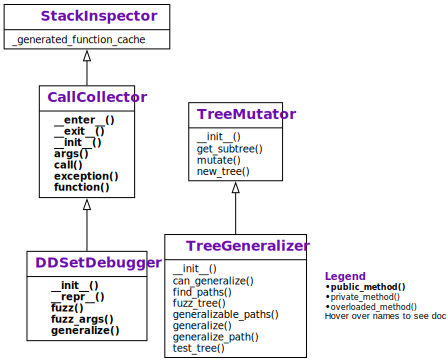

In [109]:
# ignore
display_class_hierarchy([DDSetDebugger, TreeGeneralizer],
                        public_methods=[
                            CallCollector.__init__,
                            CallCollector.__enter__,
                            CallCollector.__exit__,
                            CallCollector.function,
                            CallCollector.args,
                            CallCollector.exception,
                            CallCollector.call,  # type: ignore
                            DDSetDebugger.__init__,
                            DDSetDebugger.__repr__,
                            DDSetDebugger.fuzz,
                            DDSetDebugger.fuzz_args,
                            DDSetDebugger.generalize,
                        ], project='debuggingbook')

## Lessons Learned

* Generalizing failure-inducing inputs can yield important information for which inputs and under which circumstances a failure occurs.
* Generalizing failure-inducing inputs is most useful if the input can be split into multiple elements, of which only a part are relevant for producing the error.
* As they help in _parsing_ and _producing_ input, _grammars_ can play an important role in testing and debugging.

## Next Steps

Our [next chapter](Repairer.ipynb) introduces _automated repair_ of programs, building on the fault localization and generalization mechanisms introduced so far.

## Background

Our `DDSetDebugger` class implements the DDSET algorithm as introduced by Gopinath et al. in \cite{Gopinath2020}. A [full-fledged implementation of DDSET](https://rahul.gopinath.org/post/2020/07/15/ddset/) with plenty of details and experiments is available as a Jupyter Notebook. Our implementation follows the [simplified implementation of DDSET, as described by Gopinath](https://rahul.gopinath.org/post/2020/08/03/simple-ddset/).

The potential for determining how input features relate to bugs is not nearly explored yet. 
The ALHAZEN work by Kampmann et al. \cite{Kampmann2020} generalizes over DDSET differently, by investigating _semantic_ features of input elements such as their numeric interpretation or length and their correlation with failures. Like DDSET, ALHAZEN also uses a feedback loop to strengthen or refute its hypotheses.

In recent work \cite{Gopinath2021}, Gopinath has extended the concept of DDSET further. His work on _evocative expressions_ introduces a _pattern language_ in which arbitrary DDSET-like patterns can be combined into Boolean formula that even more precisely capture and produce failure circumstances. In particular, evocative expressions can _specialize_ grammars towards Boolean pattern combinations, thus allowing for great flexibility in testing and debugging.

## Exercises

### Exercise 1: Generalization and Specialization

Consider the abstract failure-inducing input for `BAD_INPUT` we determined:

In [110]:
all_terminals(abstract_failure_inducing_input)

'<opening-tag>"<plain-text><closing-tag>'

1. How does it change if you increase the number of test runs, using `max_tries_for_generalization`?
2. What is the success rate of the new pattern?

**Solution.** We can compute this by increasing `max_tries_for_generalization`:

In [111]:
more_precise_bitg = \
    cast(TreeGeneralizer, bad_input_tree_generalizer(max_tries_for_generalization=100))

more_precise_abstract_failure_inducing_input = \
    more_precise_bitg.generalize()

In [112]:
all_terminals(more_precise_abstract_failure_inducing_input)

'<lt><id><gt>"<plain-text><closing-tag>'

We see that we still have an opening tag; however, it no longer assumes attributes.

The success rate can be computed as before:

In [113]:
successes = 0
failures = 0
trials = 1000

for i in range(trials):
    test_input = all_terminals(
        more_precise_bitg.fuzz_tree(
            more_precise_abstract_failure_inducing_input))
    try:
        remove_html_markup(test_input)
    except AssertionError:
        successes += 1
    else:
        failures += 1

In [114]:
successes, failures

(993, 7)

In [115]:
failures / 1000

0.007

We see that the success rate is now more than 99%, which is better than before. On the other hand, the pattern is now overly _special_, since there are `<opening-tags>` with attributes such that the failure occurs (but also some that cancel out the error).